In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from plato.planets.metrics import PlanetPopulationMetrics
from plato.planets.populations import PopulationModel
from plato.stars import filter_valid_targets
from plato.visualisation import FigureProcessor, get_palette, set_plot_defaults
from plato.utils import get_abspath

In [3]:
set_plot_defaults()

figure_directory = f"/figures/07_planet_population_metrics/"
save = True

In [4]:
LOPS2 = pd.read_csv(get_abspath() + f"data/processed/LOPS2_targets.csv")
LOPN1 = pd.read_csv(get_abspath() + f"data/processed/LOPN1_targets.csv")

fields = pd.concat([LOPS2, LOPN1])
fields = filter_valid_targets(fields)
fields = fields[
    [
        "Radius",
        "Mass",
        "[Fe/H]",
        "u1",
        "u2",
        "gaiaV",
        "n_cameras",
        "Population",
    ]
]

fields["cos_i"] = 0
fields["sigma_star"] = 10e-6
fields = fields.rename(
    columns={
        "Radius": "R_star",
        "Mass": "M_star",
        "gaiaV": "Magnitude_V",
    }
)

In [5]:
metrics = PlanetPopulationMetrics()

## Recreate NGPPS II Table 7

In [6]:
metric_table = {}

for num_embryos in [10, 20, 50, 100]:
    population_model = PopulationModel(
        fields,
        num_embryos=num_embryos,
        additional_columns=["Population"],
    )

    mock = population_model.create_mock_population(additional_columns=["Population"])

    table = metrics.calculate_metrics(
        mock,
        by_population=True,
        number_of_systems={
            pop: len(fields[fields["Population"] == pop])
            for pop in fields["Population"].unique()
        },
    )
    metric_table[num_embryos] = table

metric_table = (
    pd.concat(metric_table, axis=1)
    .reindex(
        index=pd.MultiIndex.from_product(
            [
                [
                    "Thin Disk",
                    # "Thick Disk Candidate",
                    "Thick Disk",
                    # "Halo Candidate",
                    "Halo",
                ],
                ["Earth", "Super-Earth", "Neptunian", "Sub-Giant", "Giant"],
            ],
        )
    )
    .round(3)
)

In [7]:
metric_table

10                                   \
                       Number of Planets System Fraction Occurrence Rate   
Thin Disk  Earth                  193406           0.561           1.123   
           Super-Earth            247961           0.690           1.440   
           Neptunian               60661           0.288           0.352   
           Sub-Giant               24890           0.136           0.145   
           Giant                   46441           0.182           0.270   
Thick Disk Earth                    9434           0.573           1.095   
           Super-Earth             15849           0.760           1.840   
           Neptunian                2728           0.257           0.317   
           Sub-Giant                1681           0.190           0.195   
           Giant                    1742           0.136           0.202   
Halo       Earth                     404           0.534           0.863   
           Super-Earth              1322           0.934           2.825   
           Neptunian                  71           0.135           0.152   
           Sub-Giant                 177           0.378           0.378   
           Giant                      28           0.038           0.060   

                                                  20                   \
                       Multiplicity Number of Planets System Fraction   
Thin Disk  Earth              2.000            352949           0.650   
           Super-Earth        2.087            341681           0.751   
           Neptunian          1.221             65187           0.310   
           Sub-Giant          1.061             20310           0.099   
           Giant              1.484             47666           0.182   
Thick Disk Earth              1.912             17863           0.665   
           Super-Earth        2.419             19655           0.808   
           Neptunian          1.232              3449           0.331   
           Sub-Giant          1.026              1143           0.105   
           Giant              1.484              1902           0.146   
Halo       Earth              1.616               869           0.611   
           Super-Earth        3.025              1225           0.915   
           Neptunian          1.127               201           0.370   
           Sub-Giant          1.000                73           0.113   
           Giant              1.556                34           0.056   

                                                                  50   \
                       Occurrence Rate Multiplicity Number of Planets   
Thin Disk  Earth                 2.050        3.155            658423   
           Super-Earth           1.984        2.642            535657   
           Neptunian             0.379        1.222             55517   
           Sub-Giant             0.118        1.194             15745   
           Giant                 0.277        1.522             43243   
Thick Disk Earth                 2.073        3.117             35101   
           Super-Earth           2.281        2.824             20260   
           Neptunian             0.400        1.211              1633   
           Sub-Giant             0.133        1.269               455   
           Giant                 0.221        1.517              1170   
Halo       Earth                 1.857        3.038              1908   
           Super-Earth           2.618        2.862               369   
           Neptunian             0.429        1.162                11   
           Sub-Giant             0.156        1.377                 2   
           Giant                 0.073        1.308                 6   

                                                                     \
                       System Fraction Occurrence Rate Multiplicity   
Thin Disk  Earth                 0.805           3.824        4.749   
           Super-Earth           0.716         

In [8]:
# calculate the total number of planets
total_planet_number = (
    pd.DataFrame(
        metric_table[((n, "Number of Planets") for n in [10, 20, 50, 100])]
        .sum(axis=0)
        .reset_index(level=1, drop=True),
    )
    .rename(columns={0: "Total Number of Planets"})
    .rename_axis("Number of Embryos")
)
total_planet_number

,Total Number of Planets
Number of Embryos,
10,606795
20,874207
50,1369500
100,1649644


In [32]:
# print(metric_table[100].round(2).style.format('{:,}').to_latex())

## GET UNCERTAINTIES FOR HALO PLANETS, ALSO METALLICITY CUT

In [9]:
halo_table = defaultdict(dict)

for num_embryos in [10, 20, 50, 100]:
    for metallicity_name, metallicity_cut in {
        "Halo (Without [Fe/H] Cut)": None,
        "Halo (With [Fe/H] Cut)": -0.6,
    }.items():
        halo_population_model = PopulationModel(
            fields[fields["Population"] == "Halo"],
            num_embryos=num_embryos,
            additional_columns=["Population"],
        )

        halo_mocks = [
            halo_population_model.create_mock_population(
                additional_columns=["Population"],
                metallicity_limit=metallicity_cut,
            )
            for _ in range(300)
        ]

        halo_metrics = [
            metrics.calculate_number_of_planets(
                mock,
            )
            for mock in halo_mocks
        ]

        halo_metrics_stats = metrics.calculate_metrics_stats(
            halo_metrics,
            grouping_column="Planet Category",
            format_uncertainties=True,
            round_decimals="ceil",
            to_int=True,
            new_col_name="",
        )

        halo_table[num_embryos][metallicity_name] = halo_metrics_stats

halo_table = pd.concat(
    {key: pd.concat(val, axis=0) for key, val in halo_table.items()},
    axis=1,
)
halo_table.columns = halo_table.columns.droplevel(1)
halo_table = halo_table.reindex(
    ["Earth", "Super-Earth", "Neptunian", "Sub-Giant", "Giant"],
    level=1,
)

In [10]:
num_planets = (
    metric_table[:]["Number of Planets"]
    .drop(
        index=["Halo"],
        level=0,
    )
    .rename(
        index={
            "Without Limit": "Halo (Without [Fe/H] Cut])",
            "With Limit": "Halo (With [Fe/H] Cut)",
        },
        level=0,
    )
)
num_planets.columns = [10, 20, 50, 100]

halo_table = pd.concat([num_planets.round(0).astype(int), halo_table], axis=0)

In [27]:
halo_table

10                  20   \
Thin Disk                 Earth                    193406              352949   
                          Super-Earth              247961              341681   
                          Neptunian                 60661               65187   
                          Sub-Giant                 24890               20310   
                          Giant                     46441               47666   
Thick Disk                Earth                      9434               17863   
                          Super-Earth               15849               19655   
                          Neptunian                  2728                3449   
                          Sub-Giant                  1681                1143   
                          Giant                      1742                1902   
Halo (Without [Fe/H] Cut) Earth         $418^{+21}_{-22}$   $872^{+33}_{-41}$   
                          Super-Earth  $1297^{+31}_{-33}$  $1287^{+39}_{-43}$   
                          Neptunian        $81^{+9}_{-9}$   $185^{+15}_{-11}$   
                          Sub-Giant     $165^{+11}_{-11}$      $53^{+9}_{-9}$   
                          Giant            $33^{+8}_{-8}$      $31^{+8}_{-5}$   
Halo (With [Fe/H] Cut)    Earth          $58^{+10}_{-10}$   $113^{+15}_{-14}$   
                          Super-Earth    $102^{+10}_{-7}$   $127^{+11}_{-12}$   
                          Neptunian        $18^{+5}_{-4}$      $20^{+5}_{-4}$   
                          Sub-Giant        $11^{+3}_{-3}$      $10^{+4}_{-4}$   
                          Giant            $12^{+5}_{-3}$      $12^{+5}_{-4}$   

                                                      50                  100  
Thin Disk                 Earth                    658423              792594  
                          Super-Earth              535657              657960  
                          Neptunian                 55517               60298  
                          Sub-Giant                 15745               17225  
                          Giant                     43243               45663  
Thick Disk                Earth                     35101               45106  
                          Super-Earth               20260               24126  
                          Neptunian                  1633                1730  
                          Sub-Giant                   455                 514  
                          Giant                      1170                1251  
Halo (Without [Fe/H] Cut) Earth        $1917^{+64}_{-67}$  $2850^{+68}_{-81}$  
                          Super-Earth   $381^{+30}_{-30}$   $422^{+34}_{-39}$  
                          Neptunian         $7^{+2}_{-3}$       $6^{+3}_{-3}$  
                          Sub-Giant         $2^{+1}_{-1}$       $2^{+2}_{-1}$  
                          Giant             $5^{+2}_{-3}$       $5^{+2}_{-2}$  
Halo (With [Fe/H] Cut)    Earth         $234^{+26}_{-18}$   $309^{+23}_{-24}$  
                          Super-Earth   $106^{+15}_{-19}$   $127^{+15}_{-17}$  
                          Neptunian         $6^{+2}_{-3}$       $6^{+2}_{-3}$  
                          Sub-Giant         $2^{+1}_{-1}$       $2^{+2}_{-1}$  
                          Giant             $5^{+2}_{-3}$       $5^{+2}_{-2}$

In [2]:
# print(halo_table.astype(str).to_latex())

# #OR THIS WAY

# print(halo_table.style.format('{:,}').to_latex())

## OCCURENCE RATE PLOT

/tmp/ipykernel_1536347/2417850370.py:10: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  occurence_rate_barplot = sns.barplot(



/tmp/ipykernel_1536347/2417850370.py:10: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  occurence_rate_barplot = sns.barplot(



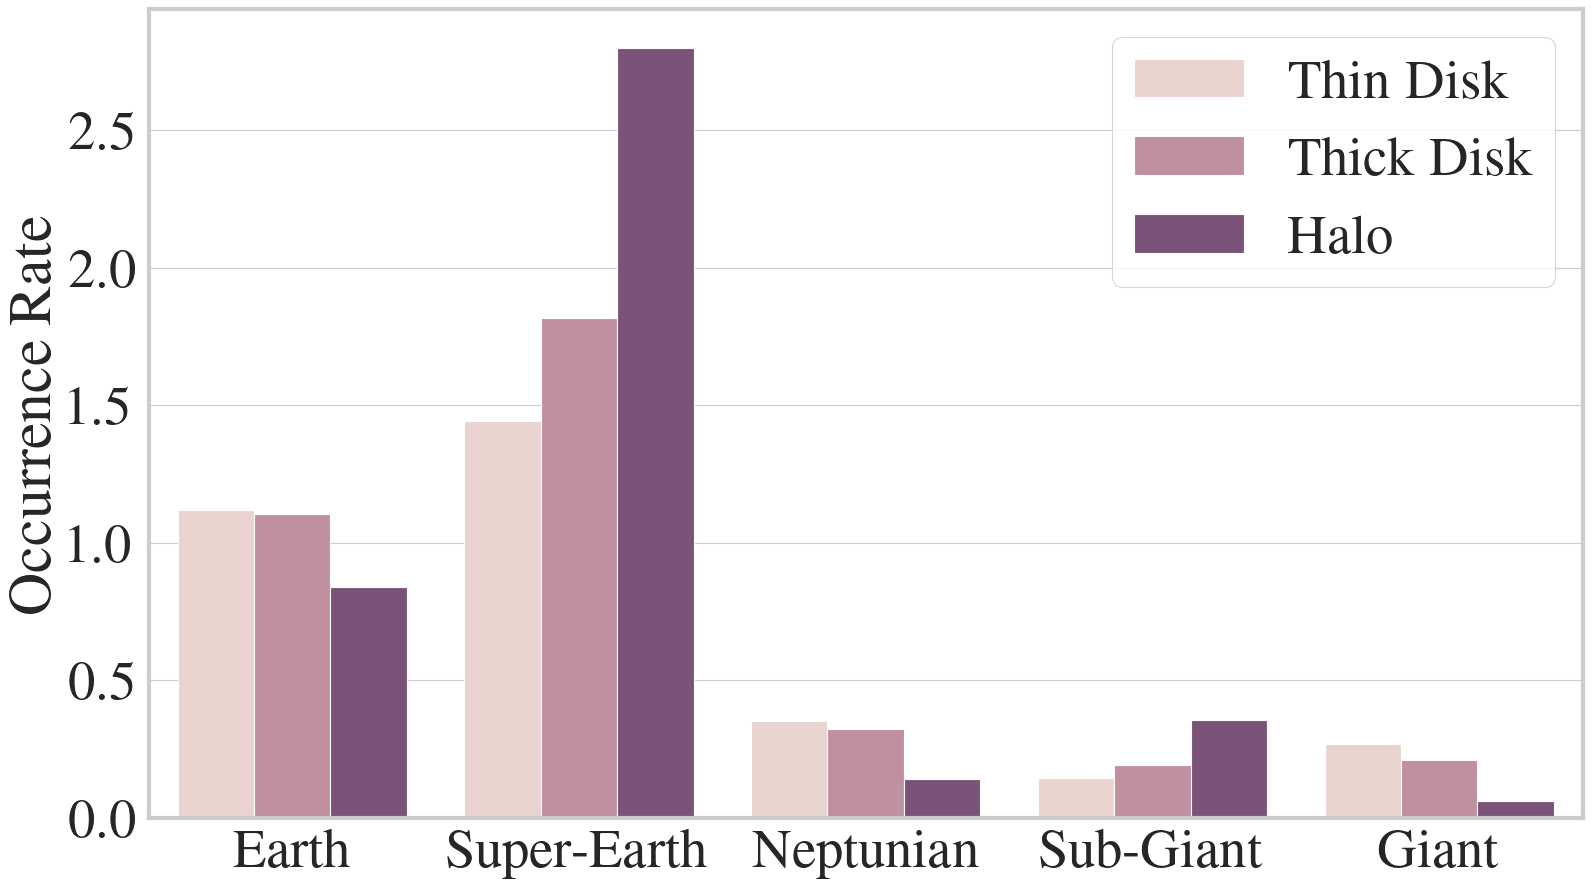

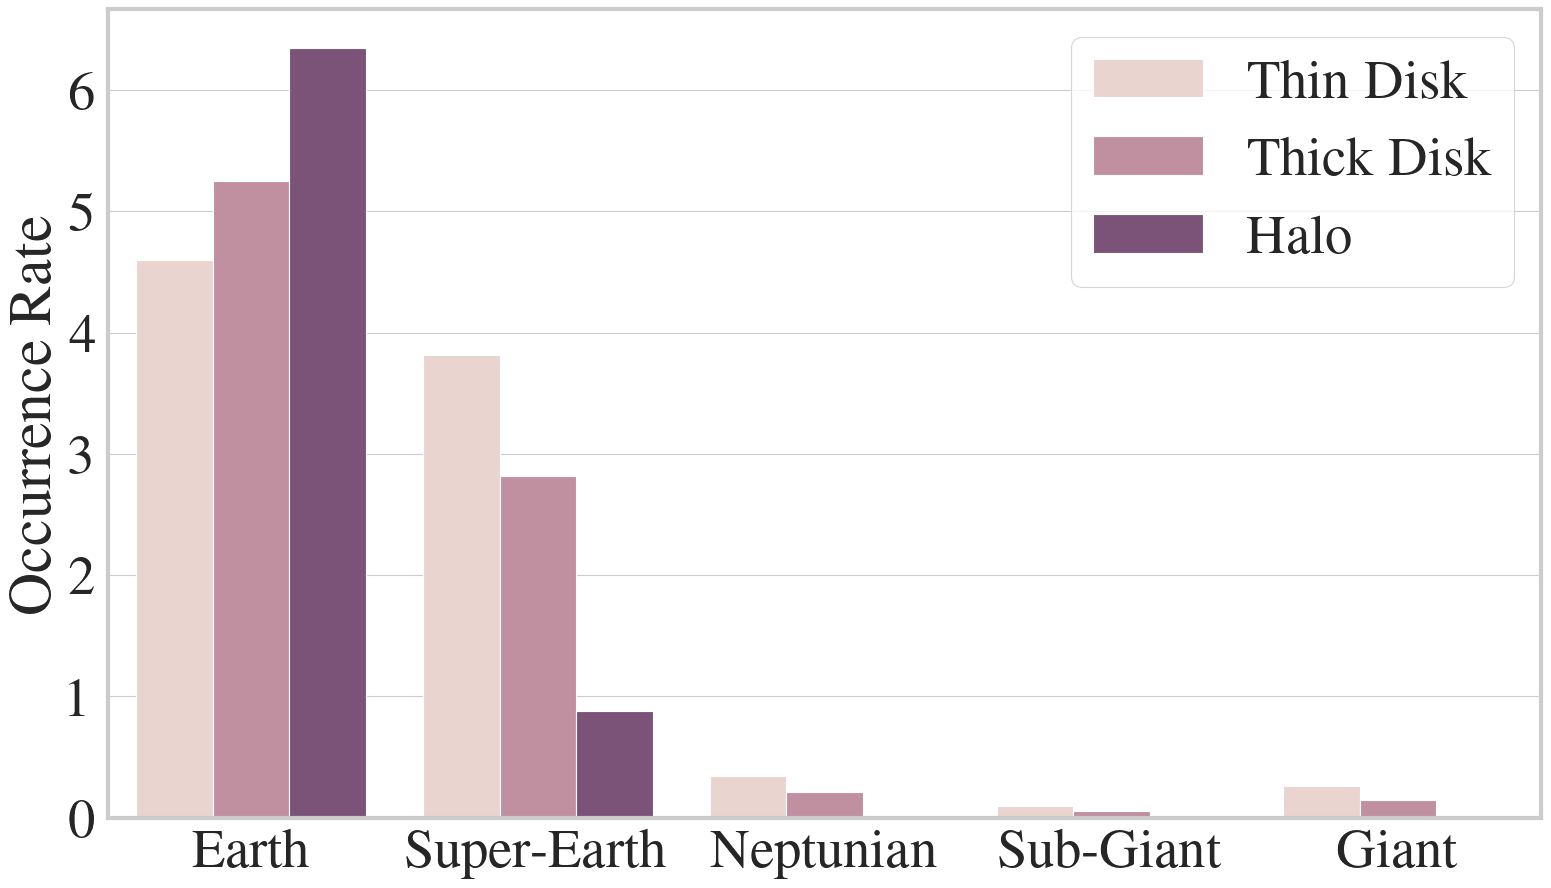

In [13]:
components = ["Thin Disk", "Thick Disk", "Halo"]

for num_embryos in [10, 100]:
    plt.figure()
    occurence_rates = metric_table[num_embryos]["Occurrence Rate"].reset_index()
    occurence_rates.rename(
        columns={"level_0": "Population", "level_1": "Planet Category"}, inplace=True
    )

    occurence_rate_barplot = sns.barplot(
        data=occurence_rates,
        x="Planet Category",
        y="Occurrence Rate",
        hue="Population",
        hue_order=components,
        palette=get_palette(n_colors=4),
    )
    occurence_rate_barplot.set_xlabel("")
    occurence_rate_barplot.legend(title="")

    FigureProcessor(occurence_rate_barplot.figure).save(
        f"occurence_rates_with_N_Embryos={num_embryos}.pdf",
        figure_directory=figure_directory,
        save=save,
    )